In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
import math
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SequentialFeatureSelector
from lightgbm import LGBMRegressor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
import boto3
import pymysql
import os

ENDPOINT = "<Enter Instance-Endpoint>"
PORT = 3306
USER = "<Your-Username>"
REGION = "<Region-of-HostedServer>"
DBNAME = "<DB-Name>"
SSLCERTIFICATE = "<Path of SSl Certificate(.pem)>"
conn = ''
os.environ['LIBMYSQL_ENABLE_CLEARTEXT_PLUGIN'] = '1'

In [3]:
#=========================Connecting to MySQL===========================
session = boto3.Session(profile_name='default')
client = session.client('rds')
token = client.generate_db_auth_token(
    DBHostname=ENDPOINT,
    Port=PORT,
    DBUsername=USER,
    Region=REGION
)

try:
    conn = pymysql.connect(
        host=ENDPOINT,
        user=USER,
        passwd=token,
        port=PORT,
        database=DBNAME,
        ssl_ca=SSLCERTIFICATE
    )
except Exception as e:
    print(f"Database connection failed due to: {e}")
    
mycursor = conn.cursor(buffered = True)
mycursor.execute("""Select * from boston_housing_21;""")
result = mycursor.fetchall()
#======================================================================

In [4]:
dataset = pd.DataFrame(result, ['PID', 'CM_ID', 'GIS_ID', 'ST_NUM', 'ST_NAME', 'UNIT_NUM', 'CITY',
       'ZIPCODE', 'BLDG_SEQ', 'NUM_BLDGS', 'LUC', 'LU', 'LU_DESC', 'BLDG_TYPE',
       'OWN_OCC', 'OWNER', 'MAIL_ADDRESSEE', 'MAIL_ADDRESS', 'MAIL_CITY',
       'MAIL_STATE', 'MAIL_ZIPCODE', 'RES_FLOOR', 'CD_FLOOR', 'RES_UNITS',
       'COM_UNITS', 'LAND_SF', 'GROSS_AREA', 'LIVING_AREA', 'LAND_VALUE',
       'BLDG_VALUE', 'TOTAL_VALUE', 'GROSS_TAX', 'YR_BUILT', 'YR_REMODEL',
       'STRUCTURE_CLASS', 'ROOF_STRUCTURE', 'ROOF_COVER', 'INT_WALL',
       'EXT_FINISHED', 'INT_COND', 'EXT_COND', 'OVERALL_COND', 'BED_RMS',
       'FULL_BTH', 'HLF_BTH', 'KITCHEN', 'TT_RMS', 'BDRM_COND', 'BTHRM_STYLE1',
       'BTHRM_STYLE2', 'BTHRM_STYLE3', 'KITCHEN_TYPE', 'KITCHEN_STYLE1',
       'KITCHEN_STYLE2', 'KITCHEN_STYLE3', 'HEAT_TYPE', 'HEAT_FUEL', 'AC_TYPE',
       'FIRE_PLACE', 'PlUMBING', 'NUM_PARKING', 'PROP_VIEW', 'CORNER_UNIT'])
dataset.head(5)

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,UNIT_NUM,CITY,ZIPCODE,BLDG_SEQ,NUM_BLDGS,...,KITCHEN_STYLE2,KITCHEN_STYLE3,HEAT_TYPE,HEAT_FUEL,AC_TYPE,FIRE_PLACE,PlUMBING,NUM_PARKING,PROP_VIEW,CORNER_UNIT
0,100001000,NaN,100001000.0,104 A 104,PUTNAM ST,NaN,EAST BOSTON,2128,1.0,1.0,...,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,NaN,NaN,3.0,A - Average,NaN
1,100002000,NaN,100002000.0,197,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,...,M - Modern,M - Modern,F - Forced Hot Air,NaN,C - Central AC,NaN,NaN,NaN,A - Average,NaN
2,100003000,NaN,100003000.0,199,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,...,S - Semi-Modern,S - Semi-Modern,S - Space Heat,NaN,N - None,NaN,NaN,NaN,A - Average,NaN
3,100004000,NaN,100004000.0,201,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,...,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,NaN,NaN,NaN,A - Average,NaN
4,100005000,NaN,100005000.0,203,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,...,S - Semi-Modern,NaN,W - Ht Water/Steam,NaN,N - None,NaN,NaN,NaN,A - Average,NaN


In [5]:
dataset.drop_duplicates(['PID'],keep= 'last', inplace=True)

In [6]:
index_names = ['PID','CM_ID','GIS_ID','ST_NUM','UNIT_NUM','MAIL_ADDRESSEE','LUC','LU', \
                       'CD_FLOOR','RES_FLOOR','RES_UNITS','COM_UNITS','LAND_SF', 'LU_DESC',\
                       'LAND_VALUE','YR_REMODEL','STRUCTURE_CLASS','ROOF_STRUCTURE', \
                       'ROOF_COVER','INT_WALL','INT_COND','BED_RMS','HLF_BTH','FULL_BTH',
                       'BDRM_COND', 'BTHRM_STYLE2','BTHRM_STYLE3','KITCHEN_STYLE2', \
                       'KITCHEN_STYLE3', 'HEAT_FUEL', 'FIRE_PLACE', 'PlUMBING', \
                       'NUM_PARKING', 'PROP_VIEW', 'CORNER_UNIT', \
                       'OWNER', 'OWN_OCC', 'ST_NAME','MAIL_ADDRESS',
                        'MAIL_CITY', 'MAIL_ZIPCODE','OVERALL_COND','KITCHEN_STYLE1']

    
    
# drop these row 
# from dataFrame
df = dataset.drop(index_names, inplace = False, axis='columns')

In [7]:
df.head()

,CITY,ZIPCODE,BLDG_SEQ,NUM_BLDGS,BLDG_TYPE,MAIL_STATE,GROSS_AREA,LIVING_AREA,BLDG_VALUE,TOTAL_VALUE,GROSS_TAX,YR_BUILT,EXT_FINISHED,EXT_COND,KITCHEN,TT_RMS,BTHRM_STYLE1,KITCHEN_TYPE,HEAT_TYPE,AC_TYPE
0,EAST BOSTON,2128,1.0,1.0,RE - Row End,MA,3353.0,2202.0,"$539,900.00","$719,400.00","$7,676.00",1900.0,A - Asbestos,F - Fair,3.0,12.0,S - Semi-Modern,3F - 3 Full Eat In Kitchens,W - Ht Water/Steam,N - None
1,EAST BOSTON,2128,1.0,1.0,RM - Row Middle,MA,3299.0,2307.0,"$564,500.00","$744,800.00","$7,947.02",1920.0,M - Vinyl,A - Average,3.0,9.0,M - Modern,3F - 3 Full Eat In Kitchens,F - Forced Hot Air,C - Central AC
2,EAST BOSTON,2128,1.0,1.0,RM - Row Middle,MA,3392.0,2268.0,"$549,700.00","$730,500.00","$7,794.44",1905.0,M - Vinyl,G - Good,3.0,13.0,M - Modern,3F - 3 Full Eat In Kitchens,S - Space Heat,N - None
3,EAST BOSTON,2128,1.0,1.0,RM - Row Middle,MA,3108.0,2028.0,"$486,500.00","$667,900.00","$7,126.49",1900.0,M - Vinyl,A - Average,3.0,11.0,S - Semi-Modern,3F - 3 Full Eat In Kitchens,W - Ht Water/Steam,N - None
4,EAST BOSTON,2128,1.0,1.0,RE - Row End,MA,3700.0,2546.0,"$511,400.00","$714,200.00","$7,620.52",1900.0,M - Vinyl,A - Average,2.0,13.0,S - Semi-Modern,2F - 2 Full Eat In Kitchens,W - Ht Water/Steam,N - None


In [8]:
df.dropna(inplace=True)

In [9]:
index_names = df[ df['MAIL_STATE'] != 'MA' ].index
df.drop(index_names, inplace = True)

In [10]:
df.drop('MAIL_STATE', inplace = True, axis='columns')

In [11]:
df['BLDG_VALUE']=df['BLDG_VALUE'].str.replace(r'[\$,]', '', regex=True).astype(float)
df['TOTAL_VALUE']=df['TOTAL_VALUE'].str.replace(r'[\$,]', '', regex=True).astype(float)
df['GROSS_TAX']=df['GROSS_TAX'].str.replace(r'[\$,]', '', regex=True).astype(float)

<Axes: ylabel='TOTAL_VALUE'>

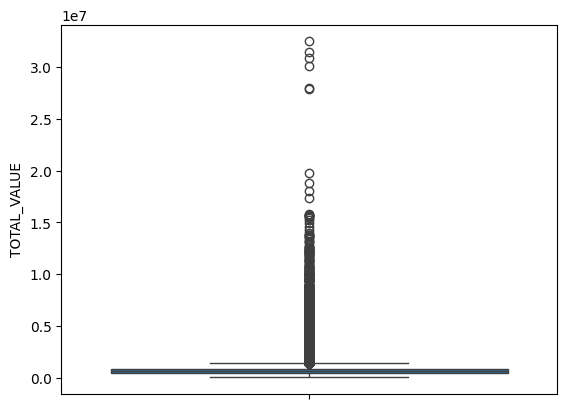

In [12]:
sns.boxplot(data=df['TOTAL_VALUE'])

In [13]:
index_names = df[ df.TOTAL_VALUE>2000000 ].index
df.drop(index_names, inplace = True)

In [14]:
## Converting numerical values into string as they are categorical values. 
df['ZIPCODE'] = df['ZIPCODE'].apply(str)
df['YR_BUILT'] = df['YR_BUILT'].apply(str)

In [15]:
df1 = df.select_dtypes(include=[object])

In [16]:
df1.columns

Index(['CITY', 'ZIPCODE', 'BLDG_TYPE', 'YR_BUILT', 'EXT_FINISHED', 'EXT_COND',
       'BTHRM_STYLE1', 'KITCHEN_TYPE', 'HEAT_TYPE', 'AC_TYPE'],
      dtype='object')

In [17]:
le = LabelEncoder()
trans_to_int= df1.apply(le.fit_transform)
trans_to_int.head()

,CITY,ZIPCODE,BLDG_TYPE,YR_BUILT,EXT_FINISHED,EXT_COND,BTHRM_STYLE1,KITCHEN_TYPE,HEAT_TYPE,AC_TYPE
0,8,18,16,104,3,2,3,3,6,2
1,8,18,17,124,9,0,1,3,1,0
2,8,18,17,109,9,3,1,3,5,2
3,8,18,17,104,9,0,3,3,6,2
4,8,18,16,104,9,0,3,2,6,2


In [18]:
df2 = df.drop(df1.columns, inplace = False, axis='columns')
df2.head(2)

,BLDG_SEQ,NUM_BLDGS,GROSS_AREA,LIVING_AREA,BLDG_VALUE,TOTAL_VALUE,GROSS_TAX,KITCHEN,TT_RMS
0,1.0,1.0,3353.0,2202.0,539900.0,719400.0,7676.00,3.0,12.0
1,1.0,1.0,3299.0,2307.0,564500.0,744800.0,7947.02,3.0,9.0


In [19]:
final_df = pd.concat([df2, trans_to_int],axis = 1)

In [20]:
final_df.columns

Index(['BLDG_SEQ', 'NUM_BLDGS', 'GROSS_AREA', 'LIVING_AREA', 'BLDG_VALUE',
       'TOTAL_VALUE', 'GROSS_TAX', 'KITCHEN', 'TT_RMS', 'CITY', 'ZIPCODE',
       'BLDG_TYPE', 'YR_BUILT', 'EXT_FINISHED', 'EXT_COND', 'BTHRM_STYLE1',
       'KITCHEN_TYPE', 'HEAT_TYPE', 'AC_TYPE'],
      dtype='object')

In [21]:
final_df['GROSS_TAX_bins'] = pd.cut(final_df.GROSS_TAX, bins=5, labels=[1,2,3,4,5], include_lowest=True)

final_df['GROSS_TAX_bins'] = [int(x) for x in final_df['GROSS_TAX_bins']]

final_df.GROSS_TAX_bins.value_counts()

GROSS_TAX_bins
2    65474
1    33580
3    15320
4     4287
5      947
Name: count, dtype: int64

In [22]:
final_df['TOTAL_VALUE_bins'] = pd.cut(final_df.BLDG_VALUE, bins=5, labels=[1,2,3,4,5], include_lowest=True)

final_df['TOTAL_VALUE_bins'] = [int(x) for x in final_df['TOTAL_VALUE_bins']]

final_df.TOTAL_VALUE_bins.value_counts()

TOTAL_VALUE_bins
2    59094
1    41746
3    13255
4     3891
5     1622
Name: count, dtype: int64

In [23]:
index_names = ['TOTAL_VALUE','BLDG_VALUE','GROSS_TAX'] 
final_df = final_df.drop(index_names, inplace = False, axis='columns')

# Vector Inflation Fator

In [24]:
#====================1. Verifying Vector Inflation Factor==========================
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = final_df.drop(['TOTAL_VALUE_bins'], axis=1)
# VIF dataframe
inf_data = pd.DataFrame()
inf_data["feature"] = X.columns
inf_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(inf_data)

           feature          VIF
0         BLDG_SEQ  1811.051453
1        NUM_BLDGS     1.042021
2       GROSS_AREA    33.108900
3      LIVING_AREA    26.485995
4          KITCHEN     4.579493
5           TT_RMS    10.610755
6             CITY     1.394325
7          ZIPCODE     1.243119
8        BLDG_TYPE     1.197754
9         YR_BUILT     1.257707
10    EXT_FINISHED     1.451419
11        EXT_COND     1.319150
12    BTHRM_STYLE1     1.325285
13    KITCHEN_TYPE     3.655332
14       HEAT_TYPE     1.323527
15         AC_TYPE     1.884788
16  GROSS_TAX_bins     1.594462


In [25]:
index_names = ['BLDG_SEQ'] 
final_df = final_df.drop(index_names, inplace = False, axis='columns')

In [26]:
#====================2. Verifying Vector Inflation Factor==========================
X = final_df.drop(['TOTAL_VALUE_bins'], axis=1)
inf_data = pd.DataFrame()
inf_data["feature"] = X.columns
inf_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(inf_data)

           feature        VIF
0        NUM_BLDGS  77.625444
1       GROSS_AREA  96.163640
2      LIVING_AREA  93.747889
3          KITCHEN  23.167277
4           TT_RMS  41.928119
5             CITY   4.338028
6          ZIPCODE   9.849952
7        BLDG_TYPE   7.757946
8         YR_BUILT  14.181773
9     EXT_FINISHED   7.349462
10        EXT_COND   2.132260
11    BTHRM_STYLE1   6.442493
12    KITCHEN_TYPE  11.809041
13       HEAT_TYPE   4.627079
14         AC_TYPE   5.388078
15  GROSS_TAX_bins  11.052882


In [27]:
index_names = ['NUM_BLDGS','GROSS_AREA','TT_RMS','LIVING_AREA','ZIPCODE'] 
final_df = final_df.drop(index_names, inplace = False, axis='columns')

In [28]:
#====================3. Verifying Vector Inflation Factor==========================
X = final_df.drop(['TOTAL_VALUE_bins'], axis=1)
inf_data = pd.DataFrame()
inf_data["feature"] = X.columns
inf_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(inf_data)

           feature        VIF
0          KITCHEN   6.822516
1             CITY   3.879855
2        BLDG_TYPE   7.135383
3         YR_BUILT  10.083273
4     EXT_FINISHED   6.375018
5         EXT_COND   2.090385
6     BTHRM_STYLE1   5.771876
7     KITCHEN_TYPE   4.883108
8        HEAT_TYPE   4.436231
9          AC_TYPE   4.808574
10  GROSS_TAX_bins   7.597339


In [29]:
#====================Removing Year Columnn=================
index_names = ['YR_BUILT'] 
final_df = final_df.drop(index_names, inplace = False, axis='columns')

In [30]:
#====================4. Verifying Vector Inflation Factor==========================
X = final_df.drop(['TOTAL_VALUE_bins'], axis=1)
inf_data = pd.DataFrame()
inf_data["feature"] = X.columns
inf_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(inf_data)

          feature       VIF
0         KITCHEN  6.819874
1            CITY  3.558453
2       BLDG_TYPE  6.970190
3    EXT_FINISHED  5.973974
4        EXT_COND  2.045493
5    BTHRM_STYLE1  5.554105
6    KITCHEN_TYPE  4.202457
7       HEAT_TYPE  4.435504
8         AC_TYPE  4.772157
9  GROSS_TAX_bins  7.314526


In [31]:
Models = []

In [32]:
final_df.corr()

,KITCHEN,CITY,BLDG_TYPE,EXT_FINISHED,EXT_COND,BTHRM_STYLE1,KITCHEN_TYPE,HEAT_TYPE,AC_TYPE,GROSS_TAX_bins,TOTAL_VALUE_bins
KITCHEN,1.000000,0.104035,-0.016981,0.212442,-0.203463,0.137669,-0.372287,0.157196,0.290123,0.273593,0.097349
CITY,0.104035,1.000000,-0.207479,0.375742,-0.107021,0.055045,-0.419104,0.014036,0.098712,-0.121050,-0.258976
BLDG_TYPE,-0.016981,-0.207479,1.000000,-0.251716,0.096937,-0.039946,0.327830,-0.082417,-0.103585,0.045774,0.147371
EXT_FINISHED,0.212442,0.375742,-0.251716,1.000000,-0.231192,0.109708,-0.494600,0.133847,0.229223,-0.031737,-0.199197
EXT_COND,-0.203463,-0.107021,0.096937,-0.231192,1.000000,-0.300429,0.333651,-0.261162,-0.407582,0.152941,0.290618
BTHRM_STYLE1,0.137669,0.055045,-0.039946,0.109708,-0.300429,1.000000,-0.225280,0.272028,0.401934,-0.265090,-0.380003
KITCHEN_TYPE,-0.372287,-0.419104,0.327830,-0.494600,0.333651,-0.225280,1.000000,-0.256208,-0.405132,-0.064306,0.267932
HEAT_TYPE,0.157196,0.014036,-0.082417,0.133847,-0.261162,0.272028,-0.256208,1.000000,0.458081,-0.057933,-0.161333
AC_TYPE,0.290123,0.098712,-0.103585,0.229223,-0.407582,0.401934,-0.405132,0.458081,1.000000,-0.220206,-0.368022
GROSS_TAX_bins,0.273593,-0.121050,0.045774,-0.031737,0.152941,-0.265090,-0.064306,-0.057933,-0.220206,1.000000,0.783315


In [33]:
X= final_df.drop(['TOTAL_VALUE_bins'], axis=1)
y=final_df['TOTAL_VALUE_bins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [34]:
print('X_train: ',X_train.shape)
print('X_test: ',X_test.shape)
print('y_train: ',y_train.shape)
print('y_test: ',y_test.shape)

X_train:  (83725, 10)
X_test:  (35883, 10)
y_train:  (83725,)
y_test:  (35883,)


In [35]:
model = LinearRegression()
start_time = time.time()
model = LinearRegression().fit(X_train, y_train)
print(f"Total time taken for training the model {(time.time() - start_time)}")
r_sq = model.score(X_test, y_test)
print('Coefficient of Determination:', r_sq)

Total time taken for training the model 0.013223409652709961
Coefficient of Determination: 0.7337858780050132


In [36]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:       TOTAL_VALUE_bins   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.779e+05
Date:                Thu, 08 Aug 2024   Prob (F-statistic):                        0.00
Time:                        01:23:12   Log-Likelihood:                         -48766.
No. Observations:               83725   AIC:                                  9.755e+04
Df Residuals:                   83715   BIC:                                  9.765e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [37]:
pred = model.predict(X_test)
prediction = list(map(round, pred))
accuracy = accuracy_score(y_test, prediction)
Models.append(['Linear Regression', accuracy])
accuracy

0.7503831898113312

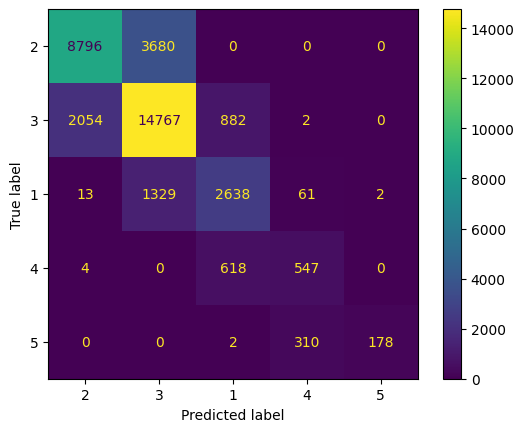

In [38]:
#=====================Confusion Matrix for Linear Regression=========================
cm = confusion_matrix(y_test, prediction)
dictsplay_labels=y.unique()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dictsplay_labels)
disp = disp.plot()
plt.show()

# Random Forest

In [39]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [40]:
start_time = time.time()
regr.fit(X_train, y_train)
print(f"Total time taken for training the model {(time.time() - start_time)}")

Total time taken for training the model 1.8206145763397217


In [41]:
y_pred=regr.predict(X_test)
regr.score(X_test, y_test)
accuracy = regr.score(X_test, y_test)
Models.append(['Random Forest',accuracy])
accuracy

0.6262424107927356

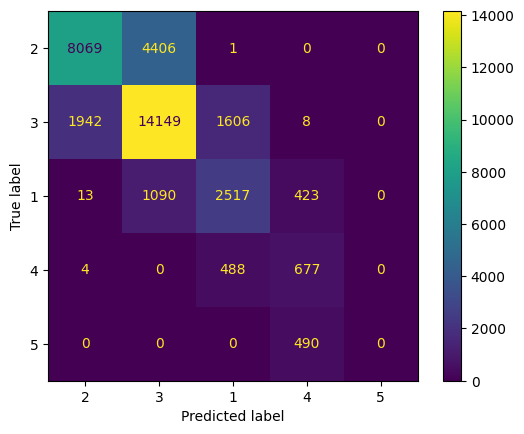

In [42]:
#=====================Confusion Matrix for Random Forest=========================
pred = regr.predict(X_test)
prediction = list(map(round, pred))
cm_regr=confusion_matrix(y_test, prediction)
dictsplay_labels=y.unique()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_regr, display_labels=dictsplay_labels)
disp = disp.plot()
plt.show()

In [43]:
sfs = SequentialFeatureSelector(regr, n_features_to_select=3)
sfs.fit(X_train, y_train)
sfs.get_feature_names_out()

array(['KITCHEN', 'CITY', 'GROSS_TAX_bins'], dtype=object)

# LightGBM Regression

In [44]:
start_time = time.time()
lgb_model = LGBMRegressor(subsample=0.9,force_row_wise= True)
lgb_model.fit(X_train, y_train)
print(f"Total time taken for training the model {(time.time() - start_time)}")

[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 83725, number of used features: 10
[LightGBM] [Info] Start training from score 1.866014
Total time taken for training the model 0.6304943561553955


In [45]:
#==================Calculating Accuracy of LightGBM==================
accuracy = lgb_model.score(X_train, y_train)
Models.append(['LightGBM',accuracy]) # LightGBM Regression accuracy

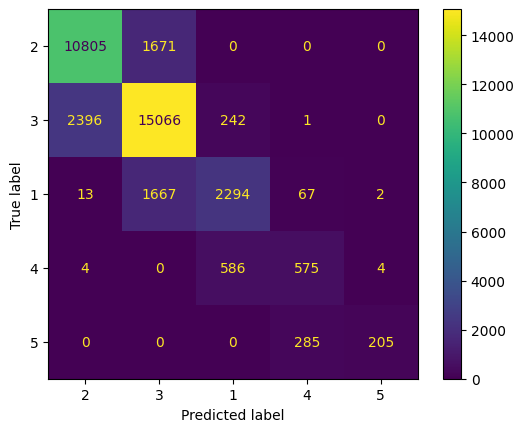

In [46]:
#=====================Confusion Matrix for LightGBM=========================
pred = lgb_model.predict(X_test)
prediction = list(map(round, pred))
cm = confusion_matrix(y_test, prediction)
dictsplay_labels=y.unique()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dictsplay_labels)
disp = disp.plot()
plt.show()

# Model with Regularization
## RIDGE Regression

In [47]:
start_time = time.time()
ridge = Ridge(alpha=1.0).fit(X_train, y_train)
print(f"Total time taken for training the model {(time.time() - start_time)}")

Total time taken for training the model 0.015706300735473633


In [48]:
accuracy = ridge.score(X_train, y_train)
Models.append(['Ridge Regression',accuracy])# Ridge Regression accuracy
accuracy

0.7309096877631966

# LASSO Regression

In [49]:
start_time = time.time()
lasso = Lasso(alpha=0.01).fit(X_train, y_train) 
print(f"Total time taken for training the model {(time.time() - start_time)}")
pred_train_lasso = lasso.predict(X_train)

Total time taken for training the model 0.018159866333007812


In [50]:
accuracy = lasso.score(X_train, y_train)
Models.append(['Lasso Regression',accuracy]) # Lasso Regression
accuracy

0.730132557895169

In [51]:
mod_df = pd.DataFrame(Models,columns=['Model','Accuracy'])

mod_df.sort_values(by=['Accuracy'],inplace=True,ascending=False)

<Axes: xlabel='Accuracy', ylabel='Model'>

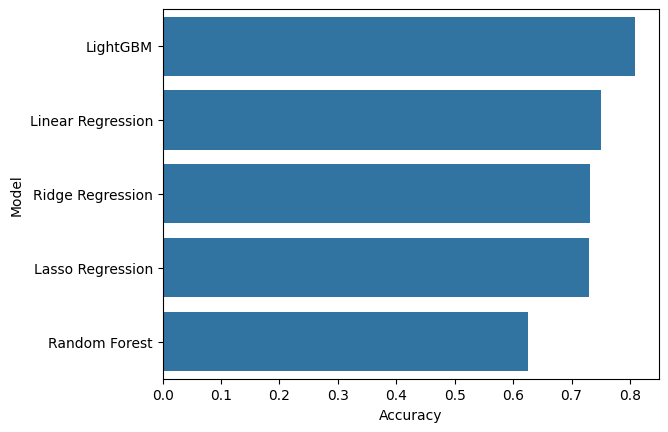

In [52]:
sns.barplot(data=mod_df, x='Accuracy', y='Model')